In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tvm
from tvm import relay
from tvm.contrib import graph_executor
from tvm.relay.testing.darknet import load_image

## Set the module path

In [2]:
lib_path = "../module/x64/yolov3.so"

params_path = "../module/x64/yolov3.params"

In [3]:
loaded_lib: tvm.runtime.Module = tvm.runtime.load_module(lib_path)
print(loaded_lib)

Module(GraphExecutorFactory, 371e818)


In [4]:
loaded_params = bytearray(open(params_path, "rb").read())

## context

In [5]:
ctx = tvm.runtime.cpu()

In [6]:
module = graph_executor.GraphModule(loaded_lib["yolov3"](ctx))

In [7]:
module.load_params(loaded_params)

### load test image

In [8]:
img_path = "../data/dog.jpg"
# img_path = "../data/eagle.jpg"
# img_path = "../data/kite.jpg"

In [9]:
img_ex = cv2.imread(img_path)
print(img_ex.shape)
# cv2.imshow("result", imagex)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(img_ex.transpose(2, 0, 1).shape)

(576, 768, 3)


In [10]:
neth = 416
netw = 416
# data = load_image(img_path, 416, 416)
# print(data.shape)

In [11]:
h_in = neth
w_in = netw
imh, imw, imc = img_ex.shape
if (w_in / imw) < (h_in / imh):
    new_w = w_in
    new_h = imh * w_in // imw
else:
    new_h = h_in
    new_w = imw * h_in // imh
dim = (new_w, new_h)
# print(dim)
resized = cv2.resize(src=img_ex, dsize=dim, interpolation=cv2.INTER_CUBIC)

imagex = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

# print(imagex.shape)

# src_h = imagex.rows()
# src_w = imagex.cols
# src_c = imagex.channeels
# imagex.reshape(0, 312 * 416)
# imagex = np.array(imagex)
imagex = imagex.transpose((2, 0, 1))

# print(imagex)
imagex = np.divide(imagex, 255.0)
# imagex = cv2.normalize(imagex, None, 1.0, 0.0, cv2.NORM_INF)
# imagex = imagex.convertTo(CV_32F, 1.0 / 255, 0)
# print(imagex.shape)
# print(imagex)
# print(imagex[0][0][0])
# print(imagex[0][0][1])
# print(imagex[0][0][2])
imagex = np.flip(imagex, 0)
# imagex = cv2.cvtColor(imagex, cv2.COLOR_RGB2BGR)
# r = imagex[0].copy()
# g = imagex[1].copy()
# b = imagex[2].copy()

# imagex[0] = b
# imagex[1] = g
# imagex[2] = r
# print("----------------")
# print(imagex)


boxed = np.full((imc, h_in, w_in), 0.5, dtype=float)
# print(boxed.shape)
_, resizedh, resizedw = imagex.shape

# print(imagex.shape)
boxed[
    :,
    int((h_in - new_h) / 2) : int((h_in - new_h) / 2) + resizedh,
    int((w_in - new_w) / 2) : int((w_in - new_w) / 2) + resizedw,
] = imagex

data = boxed
# print(data[0][52])


In [12]:
module.set_input("data", tvm.nd.array(data.astype("float32")))

In [13]:
module.run()

In [14]:
# get outputs
tvm_out = []

In [49]:
for i in range(3):
    layer_out = {}
    layer_out["type"] = "Yolo"
    # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
#     print(module.get_output(0).shape)
    layer_attr = module.get_output(i * 4 + 3).numpy()
    print(layer_attr)
    layer_out["biases"] = module.get_output(i * 4 + 2).numpy()
    print(layer_out["biases"].dtype)
    layer_out["mask"] = module.get_output(i * 4 + 1).numpy()
    print(layer_out["mask"].dtype)
    out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
    print(out_shape)
    print(module.get_output(i * 4).shape)
    layer_out["output"] = module.get_output(i * 4).numpy().reshape(out_shape)
    print(layer_out["output"].dtype)
    layer_out["classes"] = layer_attr[4]
    print(layer_out["classes"])
    tvm_out.append(layer_out)

[  3 255  52  52  80   9]
float32
int32
(3, 85, 52, 52)
(1, 255, 52, 52)
float32
80
[  3 255  26  26  80   9]
float32
int32
(3, 85, 26, 26)
(1, 255, 26, 26)
float32
80
[  3 255  13  13  80   9]
float32
int32
(3, 85, 13, 13)
(1, 255, 13, 13)
float32
80


In [40]:
print(layer_out["output"][1][5][:][:])

[[8.79485071e-01 6.99587166e-02 4.63953987e-03 2.94432556e-03
  2.26870319e-03 5.99284889e-03 1.05979275e-02 6.09205943e-03
  1.36378743e-02 4.47877161e-02 1.72163323e-01 8.84961039e-02
  6.89325333e-02]
 [9.80532318e-02 1.80130138e-03 1.11239008e-03 1.98764075e-03
  8.57433188e-04 1.41324115e-03 9.34494939e-03 8.05863994e-04
  4.33134567e-03 1.03923283e-03 3.65512678e-03 1.56873767e-03
  1.21459290e-02]
 [7.37854242e-02 2.28896388e-03 7.05532962e-04 5.50545333e-03
  1.04103088e-02 1.95299294e-02 7.54473777e-03 1.71278650e-03
  3.57801002e-03 1.99609995e-03 7.41605880e-04 4.24530869e-03
  3.20675448e-02]
 [5.89735769e-02 4.27351054e-03 5.53268241e-03 2.04640999e-02
  2.49874517e-02 3.46649215e-02 7.24247918e-02 7.79158324e-02
  1.83801651e-01 8.01296160e-02 1.21303938e-01 1.20143503e-01
  1.44828781e-01]
 [6.75827265e-02 4.96248063e-03 6.79169735e-03 3.67339328e-02
  5.19806035e-02 3.08020003e-02 3.10920905e-02 7.92921633e-02
  8.08575377e-02 1.98520012e-02 8.99130329e-02 1.41708016e-0

In [16]:
# thresholds
thresh = 0.5
nms_thresh = 0.45

In [17]:
# do the detection and bring up the bounding boxes
img = tvm.relay.testing.darknet.load_image_color(img_path)
_, im_h, im_w = img.shape
dets = tvm.relay.testing.yolo_detection.fill_network_boxes(
    (netw, neth), (im_w, im_h), thresh, 1, tvm_out
)

In [18]:
tvm.relay.testing.yolo_detection.do_nms_sort(dets, 80, nms_thresh)

In [19]:
coco_path = "../data/coco.names"
font_path = "../data/arial.ttf"

In [20]:
with open(coco_path) as f:
    content = f.readlines()

names = [x.strip() for x in content]

tvm.relay.testing.yolo_detection.show_detections(img, dets, thresh, names, 80)


class:['dog 0.994'] left:127 right:227 top:316 bottom:533
class:['truck 0.9266'] left:471 right:83 top:689 bottom:169
class:['bicycle 0.9984'] left:111 right:113 top:577 bottom:447


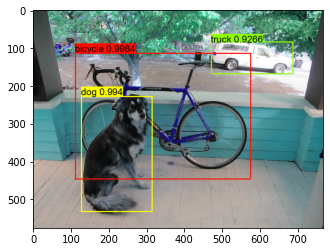

In [21]:
tvm.relay.testing.yolo_detection.draw_detections(
    font_path, img, dets, thresh, names, 80
)
plt.imshow(img.transpose(1, 2, 0))
plt.show()